In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone

def load_data(dataset_folders):
    combined_data = []
    for folder in dataset_folders:  # Update with the path to your datasets
        for filename in os.listdir(folder):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder, filename)
                # print(f"Loading {filepath}")
                participant_data = pd.read_csv(filepath)
                combined_data.append(participant_data)
    return pd.concat(combined_data, ignore_index=True)

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': [None, 'balanced']
}

param_grid_dt = {
    'criterion': ['gini', 'entropy']
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.001],
    # 'max_depth': [3, 6, 9],
    # 'subsample': [0.5, 0.7, 1.0],
    # 'colsample_bytree': [0.5, 0.7, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_lambda': [0.1, 1.0, 10.0]
}

def perform_grid_search(estimator, param_grid, X, y, scoring='accuracy', cv=5):
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring, cv=cv, verbose=1, n_jobs=-1)
    grid_search.fit(X, y)
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    return grid_search.best_estimator_

def train_test_split_by_participant(data, test_size=0.2):
    """Split data by participant for age and gender models."""
    participants = data['Participant'].unique()
    np.random.shuffle(participants)
    test_size = int(len(participants) * test_size)
    test_participants = participants[-test_size:]
    train_participants = participants[:-test_size]

    train_data = data[data['Participant'].isin(train_participants)]
    test_data = data[data['Participant'].isin(test_participants)]

    # Detailed split information
    print("Training on participants from databases:\n", train_data[['Participant', 'Database']].drop_duplicates())
    print("Testing on participants from databases:\n", test_data[['Participant', 'Database']].drop_duplicates())
    return train_data, test_data

def time_series_split(data, test_ratio=0.2):
    """Time-series split for participant ID identification."""
    train_data = data.groupby('Participant').apply(lambda x: x.iloc[:int(len(x)*(1-test_ratio))]).reset_index(drop=True)
    test_data = data.groupby('Participant').apply(lambda x: x.iloc[int(len(x)*(1-test_ratio)):]).reset_index(drop=True)
    
    # Detailed split information
    for participant, group in data.groupby('Participant'):
        train_end = int(len(group)*(1-test_ratio))
        # print(f"Participant {participant} from {group['Database'].iloc[0]}: Train indices 0 to {train_end}, Test indices {train_end} to {len(group)}")
    return train_data, test_data

def prepare_features_labels(data, label_column, encode=True):
    """Prepare features and labels for training."""
    features = data.drop(columns=['Participant', 'Sample', 'Sampling_Rate', 'Database', 'Gender', 'Age', 'age_binned'])
    labels = data[label_column]
    if encode:
        encoder = LabelEncoder()
        labels = encoder.fit_transform(labels)
    return features, labels

def run_shap_analysis(model, X_train, X_test, model_name, task, aggregate_classes=False):
    # Sample a subset of data if X_test is too large
    X_test_sample = X_train.sample(n=1000, random_state=42) if len(X_test) > 1000 else X_test
    
    # Choose the right explainer based on model type
    if model_name == 'Logistic Regression':
        explainer = shap.LinearExplainer(model=model, data=X_train, masker=shap.maskers.Independent(data=X_train))
        shap_values = explainer.shap_values(X_test_sample)
    elif model_name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        explainer = shap.TreeExplainer(model=model, data=X_train)
        shap_values = explainer.shap_values(X_test_sample, check_additivity=False)
    else:
        raise ValueError(f"Unsupported model type {model_name}")
    
    
    feature_names = X_test_sample.columns.tolist()

    # Handle multi-class outputs
    if len(shap_values.shape) == 3:
        if aggregate_classes:
            # Aggregate SHAP values across classes
            aggregated_shap_values = np.mean(np.abs(shap_values), axis=2)
            aggregated_shap_values = np.mean(shap_values, axis=2)
            plot_shap_summary(aggregated_shap_values, X_test_sample, model_name, task, feature_names=feature_names)
        else:
            # Visualize each class separately
            for i in range(shap_values.shape[2]):
                plot_shap_summary(shap_values[:, :, i], X_test_sample, model_name, task, class_index=i, feature_names=feature_names)
                # plot_decision_plot(explainer.expected_value[i], shap_values[:, :, i], feature_names, model_name, task, class_index=i)
    else:
        plot_shap_summary(shap_values, X_test_sample, model_name, task, feature_names=feature_names)
        # plot_decision_plot(explainer.expected_value, shap_values, feature_names, model_name, task)

# def plot_shap_summary(shap_values, features, model_name, task, class_index=None, feature_names=None):
#     suffix = f"_class_{class_index}" if class_index is not None else ""
#     plt.figure(figsize=(40, 12))
#     shap.summary_plot(shap_values, features=features, feature_names=feature_names, plot_type="bar", show=False)
#     plt.title(f'SHAP Summary Plot (Bar) - {model_name} for {task}{suffix}')
#     plt.savefig(f'plot/{model_name}_{task}{suffix}_shap_summary_bar.pdf')
#     plt.close()

#     plt.figure(figsize=(40, 12))
#     shap.summary_plot(shap_values, features=features, feature_names=feature_names, show=False)
#     plt.title(f'SHAP Detailed Summary Plot - {model_name} for {task}{suffix}')
#     plt.savefig(f'plot/{model_name}_{task}{suffix}_shap_detailed.pdf')
#     plt.close()

def plot_shap_summary(shap_values, features, model_name, task, class_index=None, feature_names=None):
    suffix = f"_class_{class_index}" if class_index is not None else ""
    
    # Adjust the figure size for better visibility
    plt.figure(figsize=(24, 8))
    shap.summary_plot(shap_values, features=features, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f'SHAP Summary Plot (Bar) - {model_name} for {task}{suffix}')
    plt.tight_layout()  # Adjust layout to prevent clipping of text
    plt.savefig(f'plot/{model_name}_{task}{suffix}_shap_summary_bar.pdf')
    plt.close()

    plt.figure(figsize=(18, 8))
    shap.summary_plot(shap_values, features=features, feature_names=feature_names, show=False)
    plt.title(f'SHAP Detailed Summary Plot - {model_name} for {task}{suffix}')
    plt.tight_layout()  # Adjust layout to prevent clipping of text
    plt.savefig(f'plot/{model_name}_{task}{suffix}_shap.pdf')
    plt.close()
    
def plot_decision_plot(base_value, shap_values, feature_names, model_name, task, class_index=None):
    suffix = f"_class_{class_index}" if class_index is not None else ""
    plt.figure(figsize=(40, 12))
    shap.decision_plot(base_value, shap_values, feature_names=feature_names, show=False)
    plt.title(f'Decision Plot - {model_name} for {task}{suffix} (Sample Instances)')
    plt.savefig(f'plot/{model_name}_{task}{suffix}_decision_plot.pdf')
    plt.close()

def train_and_evaluate(model, X_train, y_train, X_test, y_test, n=30):
    best_accuracy = 0
    best_model = None
    best_predictions = None
    best_probabilities = None
    best_roc_auc = None
    for _ in range(n):
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        predictions = cloned_model.predict(X_test)
        probabilities = cloned_model.predict_proba(X_test)
        accuracy = accuracy_score(y_test, predictions)
        # try:
        #     if probabilities.shape[1] == 2:
        #         roc_auc = roc_auc_score(y_test, probabilities[:, 1])
        #     else:
        #         # Binarize the output
        #         y_test_bin = label_binarize(y_test, classes=classes)
        #         roc_auc = roc_auc_score(y_test_bin, probabilities, multi_class='ovr')
        # except Exception as e:
        #     roc_auc = None
        #     print(f"ROC AUC could not be calculated: {e}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = cloned_model
            best_predictions = predictions
            best_probabilities = probabilities
            
    return best_model, best_accuracy, best_predictions, best_probabilities

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, task):
    # model.fit(X_train, y_train)
    
    model, best_accuracy, predictions, probabilities = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    print(f"Selected best model with accuracy: {best_accuracy:.4f}")
    # predictions = model.predict(X_test)
    # probabilities = model.predict_proba(X_test)
    classes = np.unique(np.concatenate([y_train, y_test]))

    # print(f"Shapes - Predictions: {predictions.shape}, Probabilities: {probabilities.shape}")

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    try:
        if probabilities.shape[1] == 2:
            roc_auc = roc_auc_score(y_test, probabilities[:, 1])
        else:
            # Binarize the output
            y_test_bin = label_binarize(y_test, classes=classes)
            roc_auc = roc_auc_score(y_test_bin, probabilities, multi_class='ovr')
    except Exception as e:
        roc_auc = None
        print(f"ROC AUC could not be calculated: {e}")

    print("Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, predictions)
    if task == 'Participant ID':
        plt.figure(figsize=(72, 54))
    else: 
        plt.figure(figsize=(12, 9))
        
    threshold = np.percentile(cm, 0)  # Adjust the percentile threshold
    mask = cm < threshold
    masked_confusion_matrix = np.where(mask, np.nan, cm)  
    sns.heatmap(masked_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
    plt.title(f'Confusion Matrix for {model_name} on {task}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'plot/Confusion_Matrix_{model_name}_{task}.pdf')  # Save the confusion matrix figure
    plt.show()

    if probabilities.shape[1] == 2:  # Only plot ROC for binary classification
        fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name} on {task}')
        plt.legend(loc="lower right")
        plt.savefig(f'plot/{model_name}_{task}_ROC_Curve.pdf')  # Save the confusion matrix figure
        plt.show()
        
    # SHAP analysis
    try:
        # run_shap_analysis(model, X_train, X_test, model_name, task)
        run_shap_analysis(model, X_train, X_test, model_name, task, aggregate_classes=True)
    except Exception as e:
        print(f"SHAP analysis failed on {task} with model {model_name}")
        print(e)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Main experiment setup
dataset_paths = ['mit-bih_features/', 'mit-long_features/', 'smart_features/', 'chfdb_features/', 'brno_features/']
combined_data = load_data(dataset_paths)
# drop the 'Half Minute' column
combined_data = combined_data.drop(columns=['Half Minute'])
combined_data['Gender'] = combined_data['Gender'].replace({'m': 'M'})

combined_data = combined_data.dropna()
unique_genders = combined_data['Gender'].unique()

age_bins = [0, 18, 35, 50, 65, 80, 100]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]}" for i in range(len(age_bins)-1)]

combined_data['age_binned'] = pd.cut(combined_data['Age'], bins=age_bins, labels=age_labels, right=False)
le = LabelEncoder()
combined_data['age_binned'] = le.fit_transform(combined_data['age_binned'])


In [ ]:
# Splitting data for age and gender identification
train_data_ag, test_data_ag = train_test_split_by_participant(combined_data, test_size=0.2)

In [3]:
# Model initialization
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'XGBoost': GradientBoostingClassifier()
}

In [ ]:
# Gender Identification
X_train, y_train = prepare_features_labels(train_data_ag, 'Gender')
X_test, y_test = prepare_features_labels(test_data_ag, 'Gender')
print("\n--- Gender Identification ---")
for name, model in models.items():
    print(f"\nModel: {name}")
    evaluate_model(model, X_train, y_train, X_test, y_test, model_name=name, task='Gender')

In [ ]:
# Age Identification (Binning ages as needed)
X_train_age, y_train_age = prepare_features_labels(train_data_ag, 'age_binned')
X_test_age, y_test_age = prepare_features_labels(test_data_ag, 'age_binned')
print("\n--- Age Identification ---")
for name, model in models.items():
    print(f"\nModel: {name}")
    evaluate_model(model, X_train_age, y_train_age, X_test_age, y_test_age, model_name=name, task='Age')

In [ ]:
age_classes = combined_data['age_binned'].unique()
age_classes


--- Participant ID Identification ---

Model: Logistic Regression


/tmp/ipykernel_2711562/17424155.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = data.groupby('Participant').apply(lambda x: x.iloc[:int(len(x)*(1-test_ratio))]).reset_index(drop=True)
/tmp/ipykernel_2711562/17424155.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = data.groupby('Participant').apply(lambda x: x.iloc[int(len(x)*(1-test_ratio)):]).reset_index(drop=True)


Selected best model with accuracy: 0.5423


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics:
Accuracy: 0.5423
Precision: 0.5267
Recall: 0.5423
F1-Score: 0.5017
ROC AUC: 0.9763


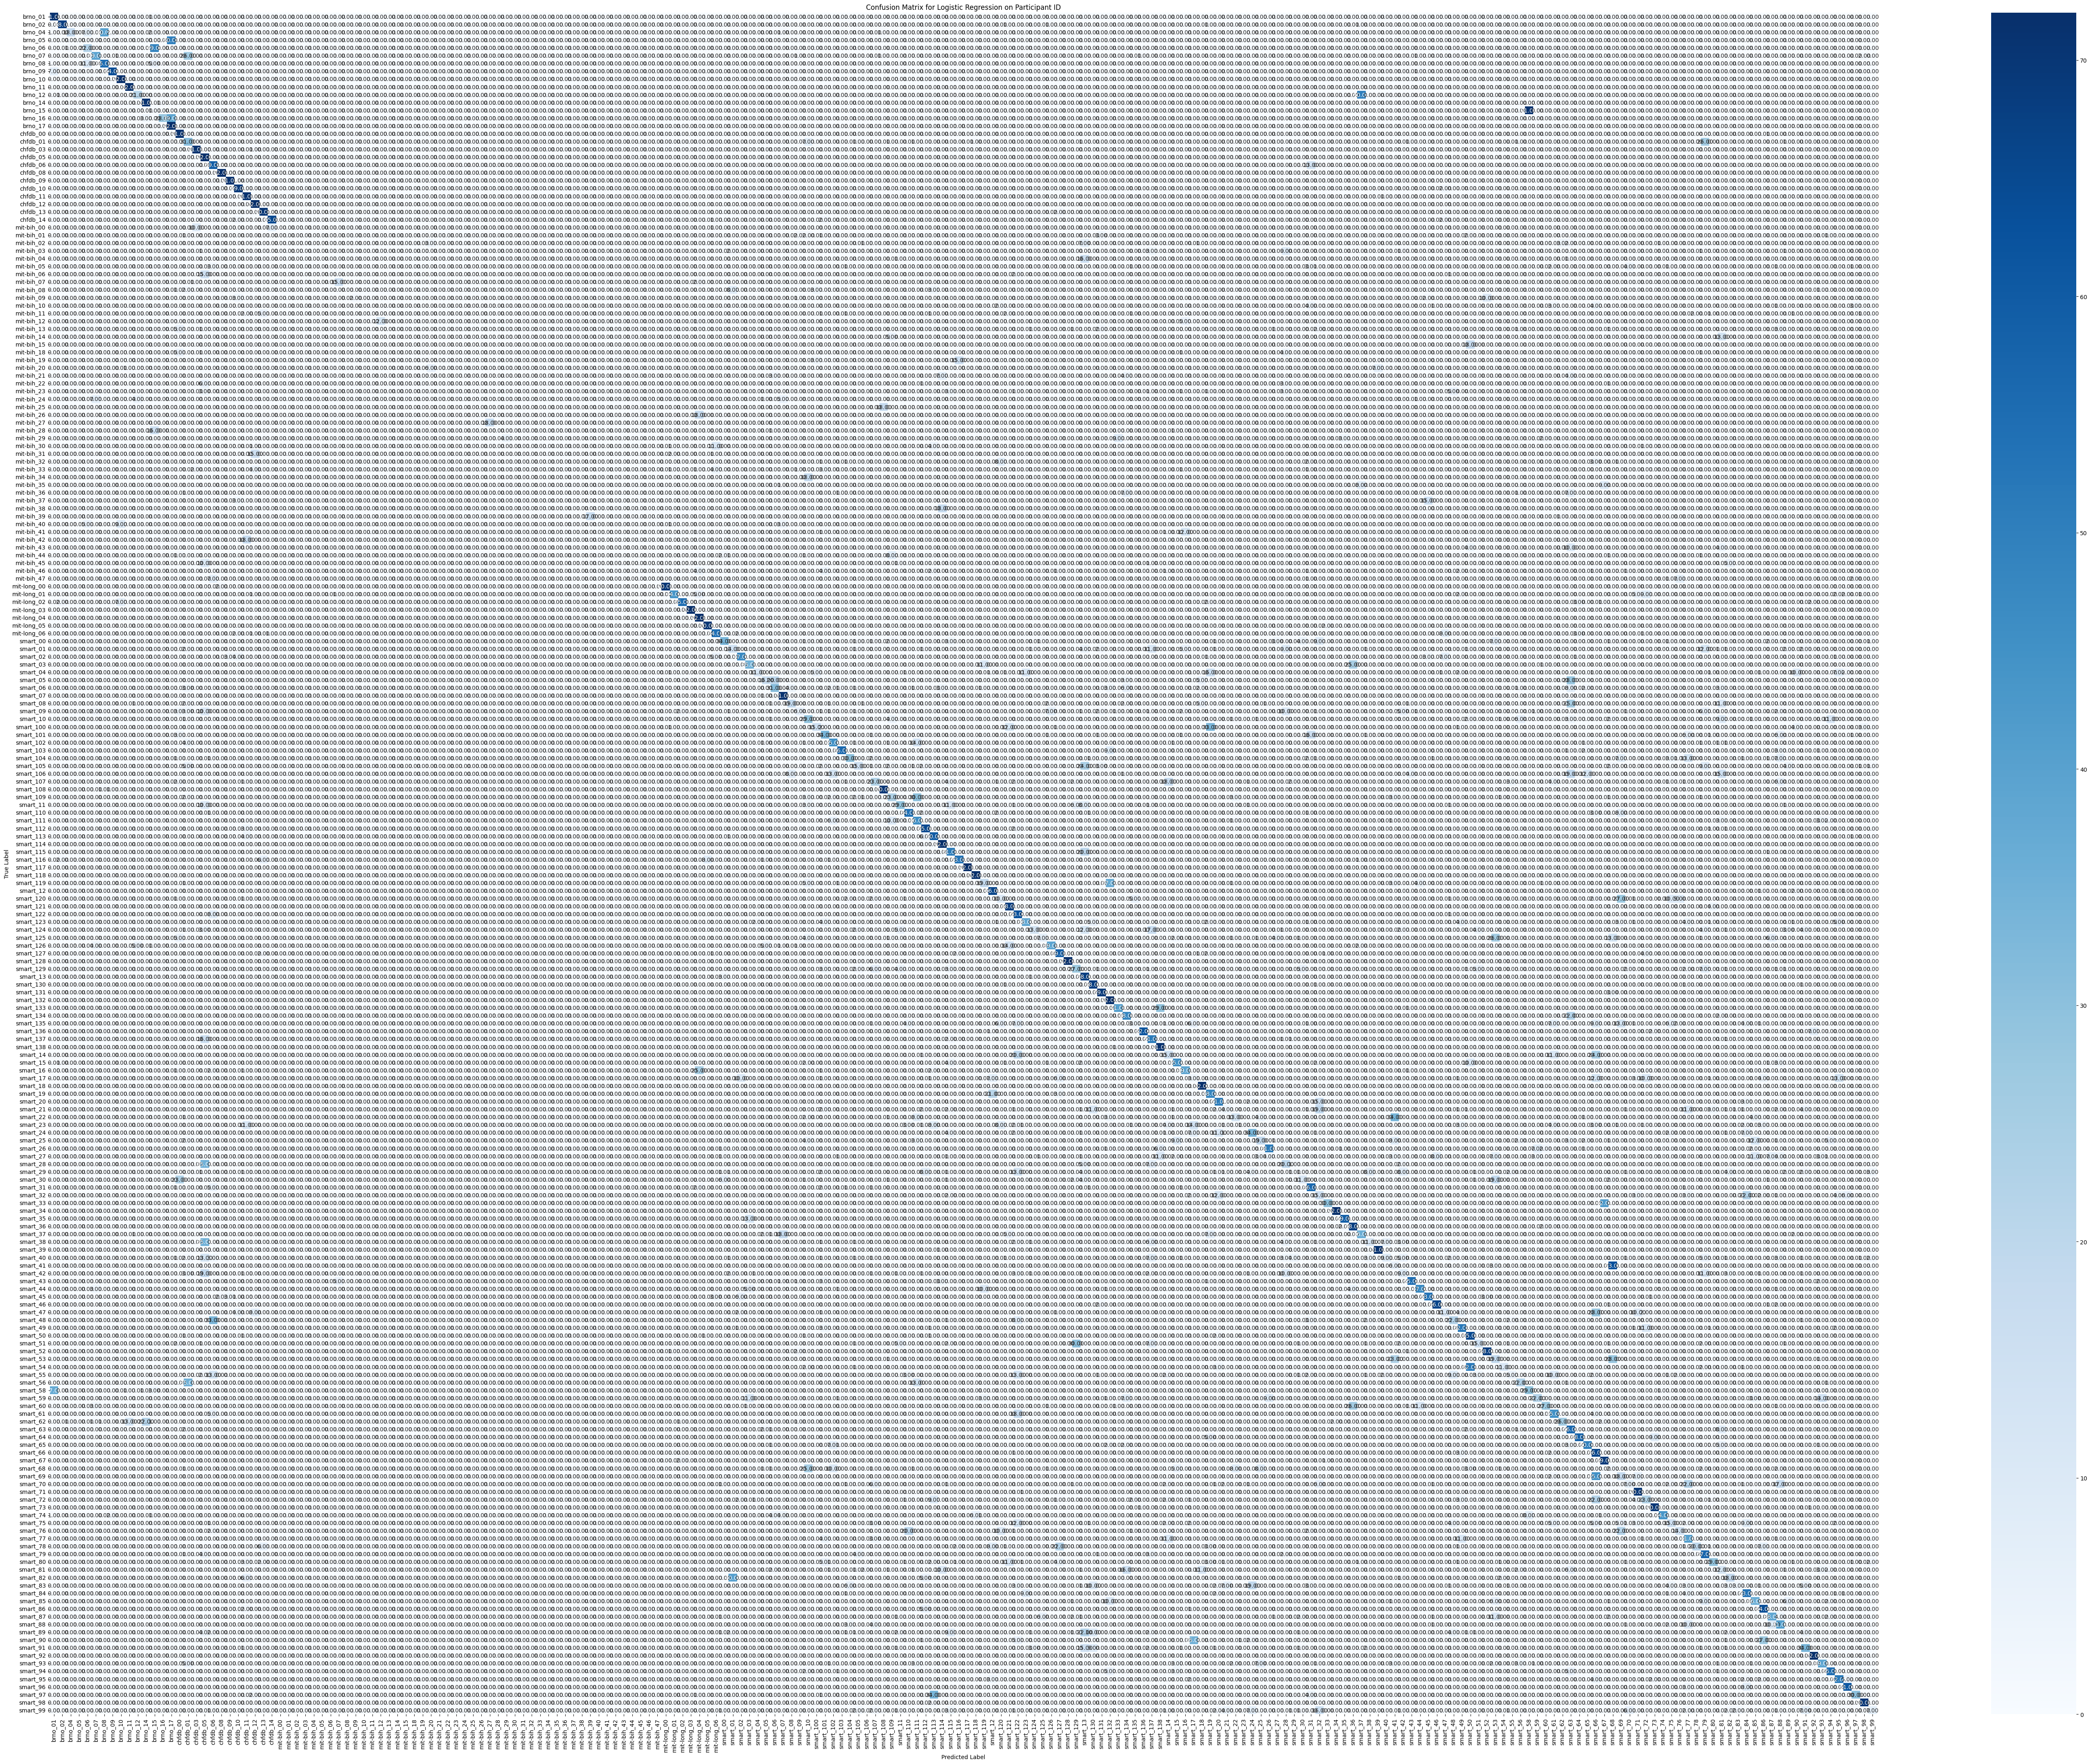


Model: Decision Tree
Selected best model with accuracy: 0.6731
Metrics:
Accuracy: 0.6731
Precision: 0.6796
Recall: 0.6731
F1-Score: 0.6674
ROC AUC: 0.8307


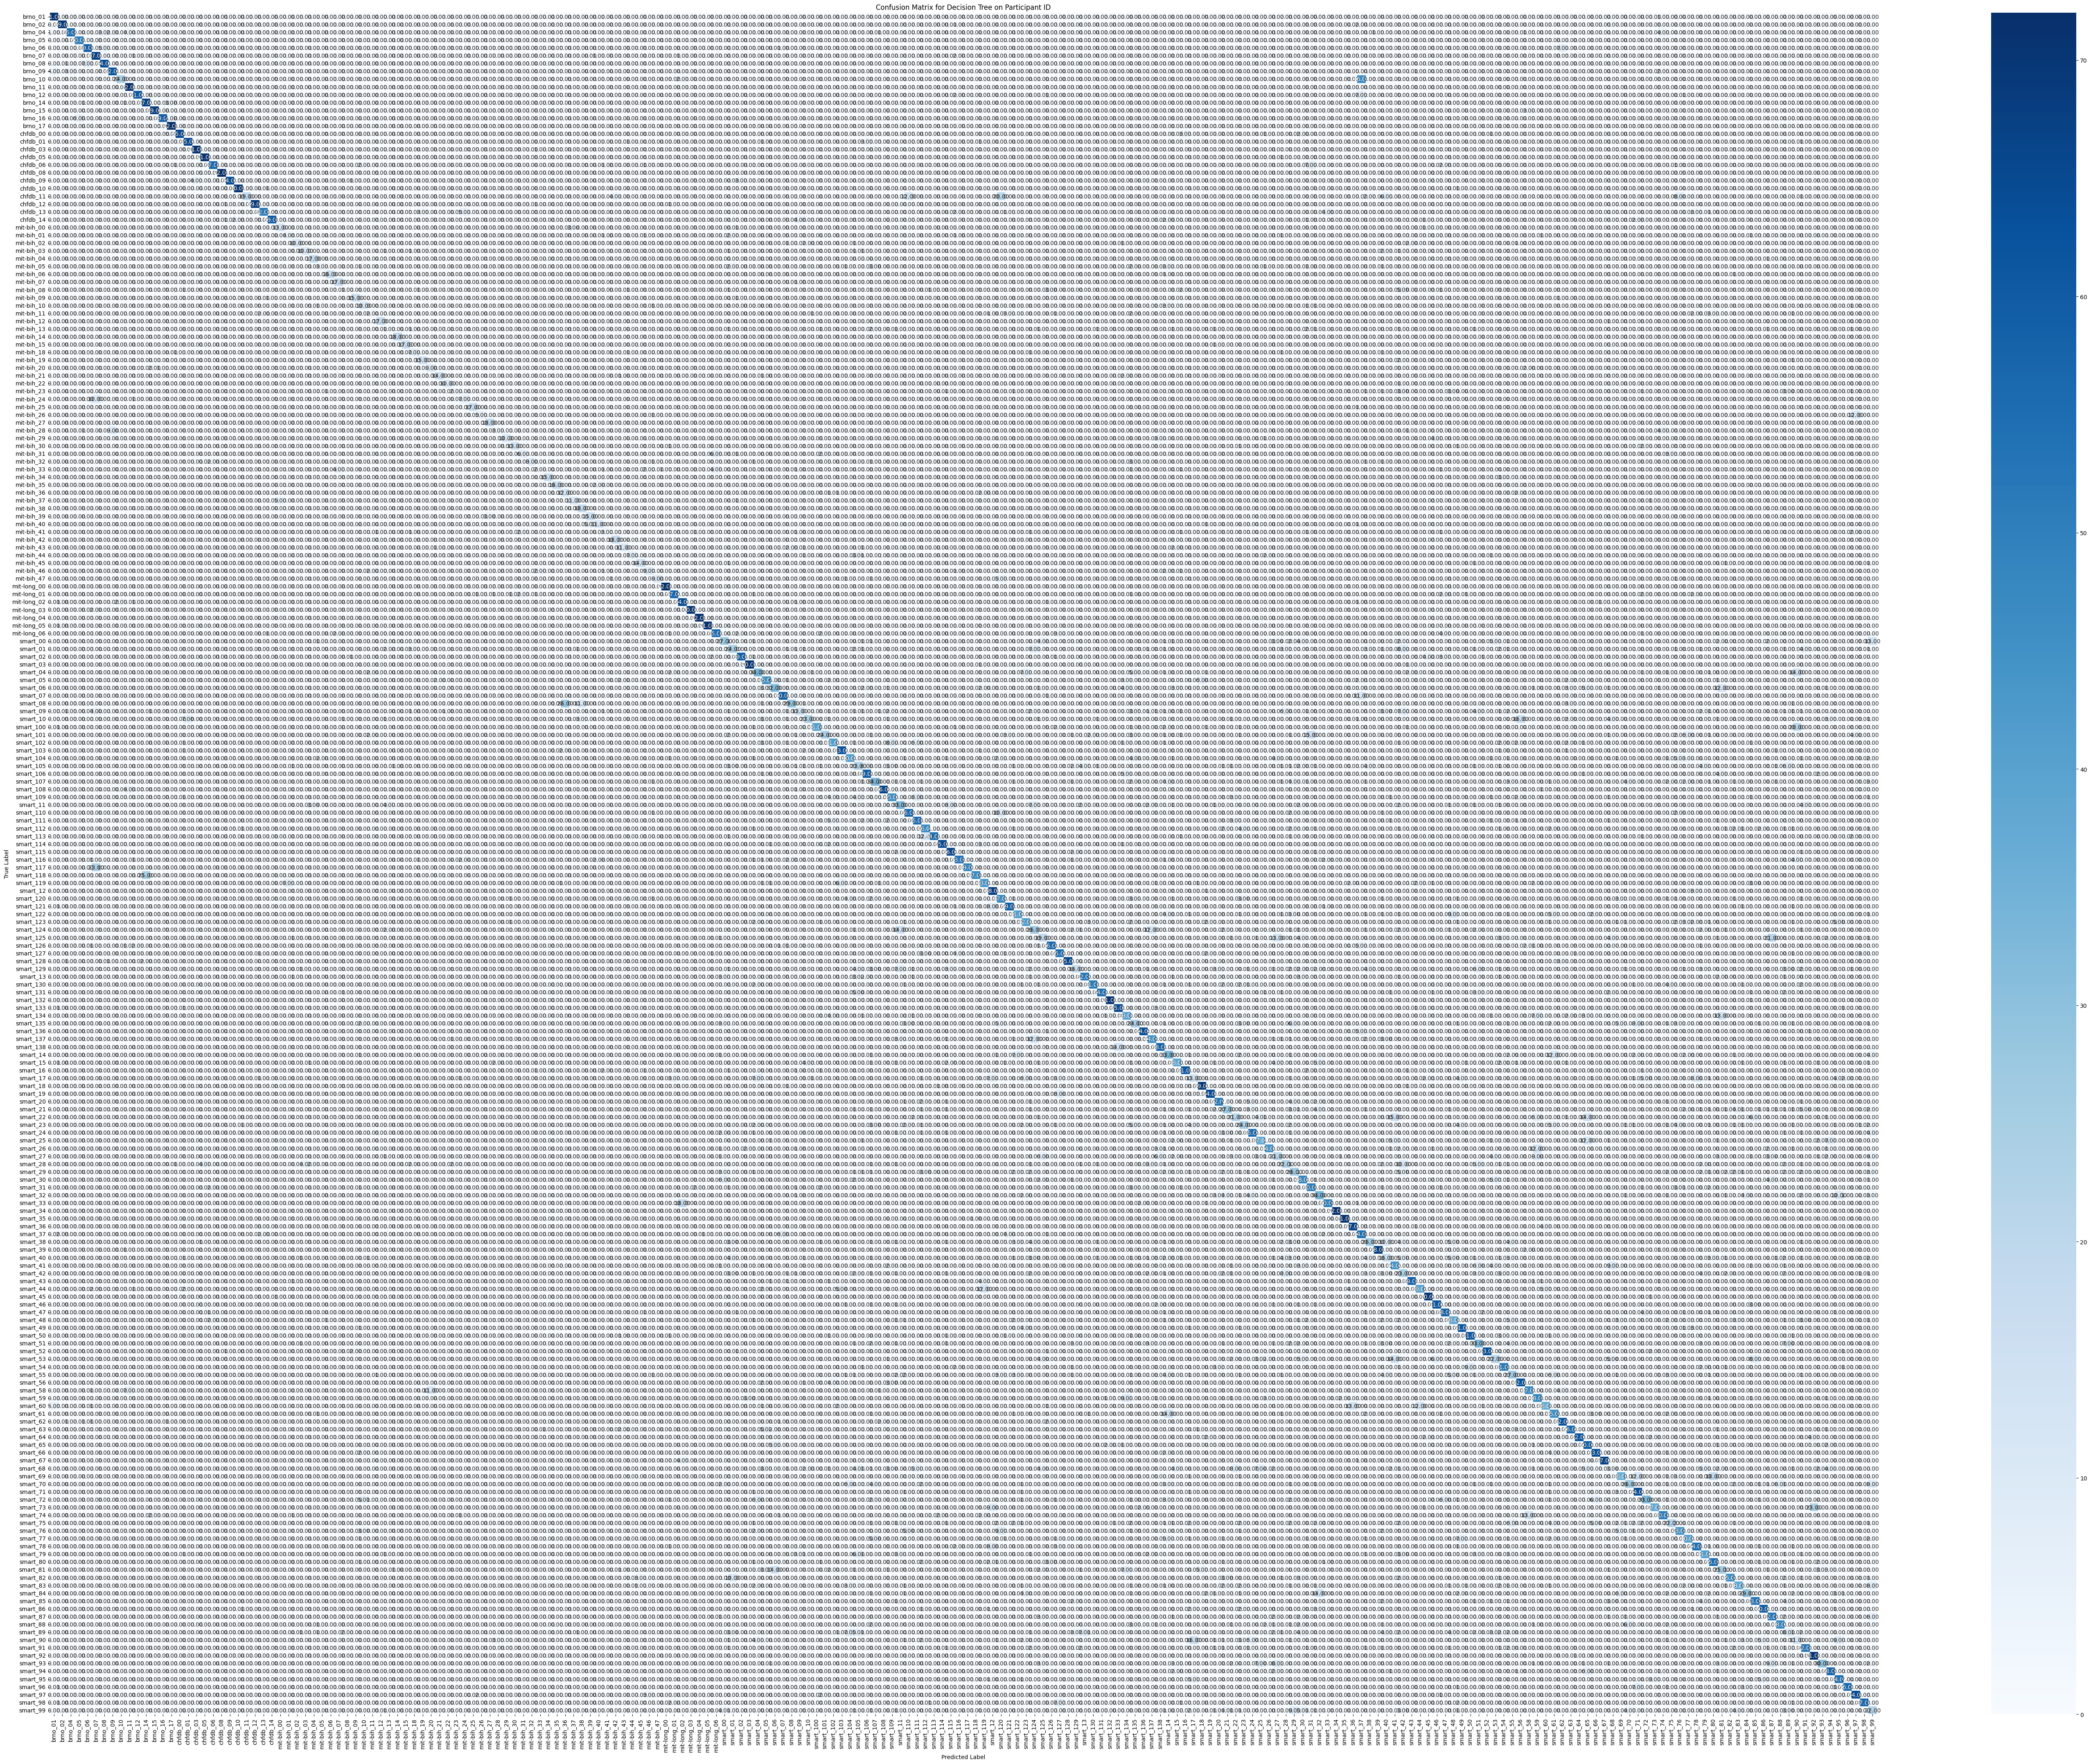

100%|===================| 217281/218000 [01:37<00:00]        


Model: Random Forest
Selected best model with accuracy: 0.8151
Metrics:
Accuracy: 0.8151
Precision: 0.8125
Recall: 0.8151
F1-Score: 0.8067
ROC AUC: 0.9903


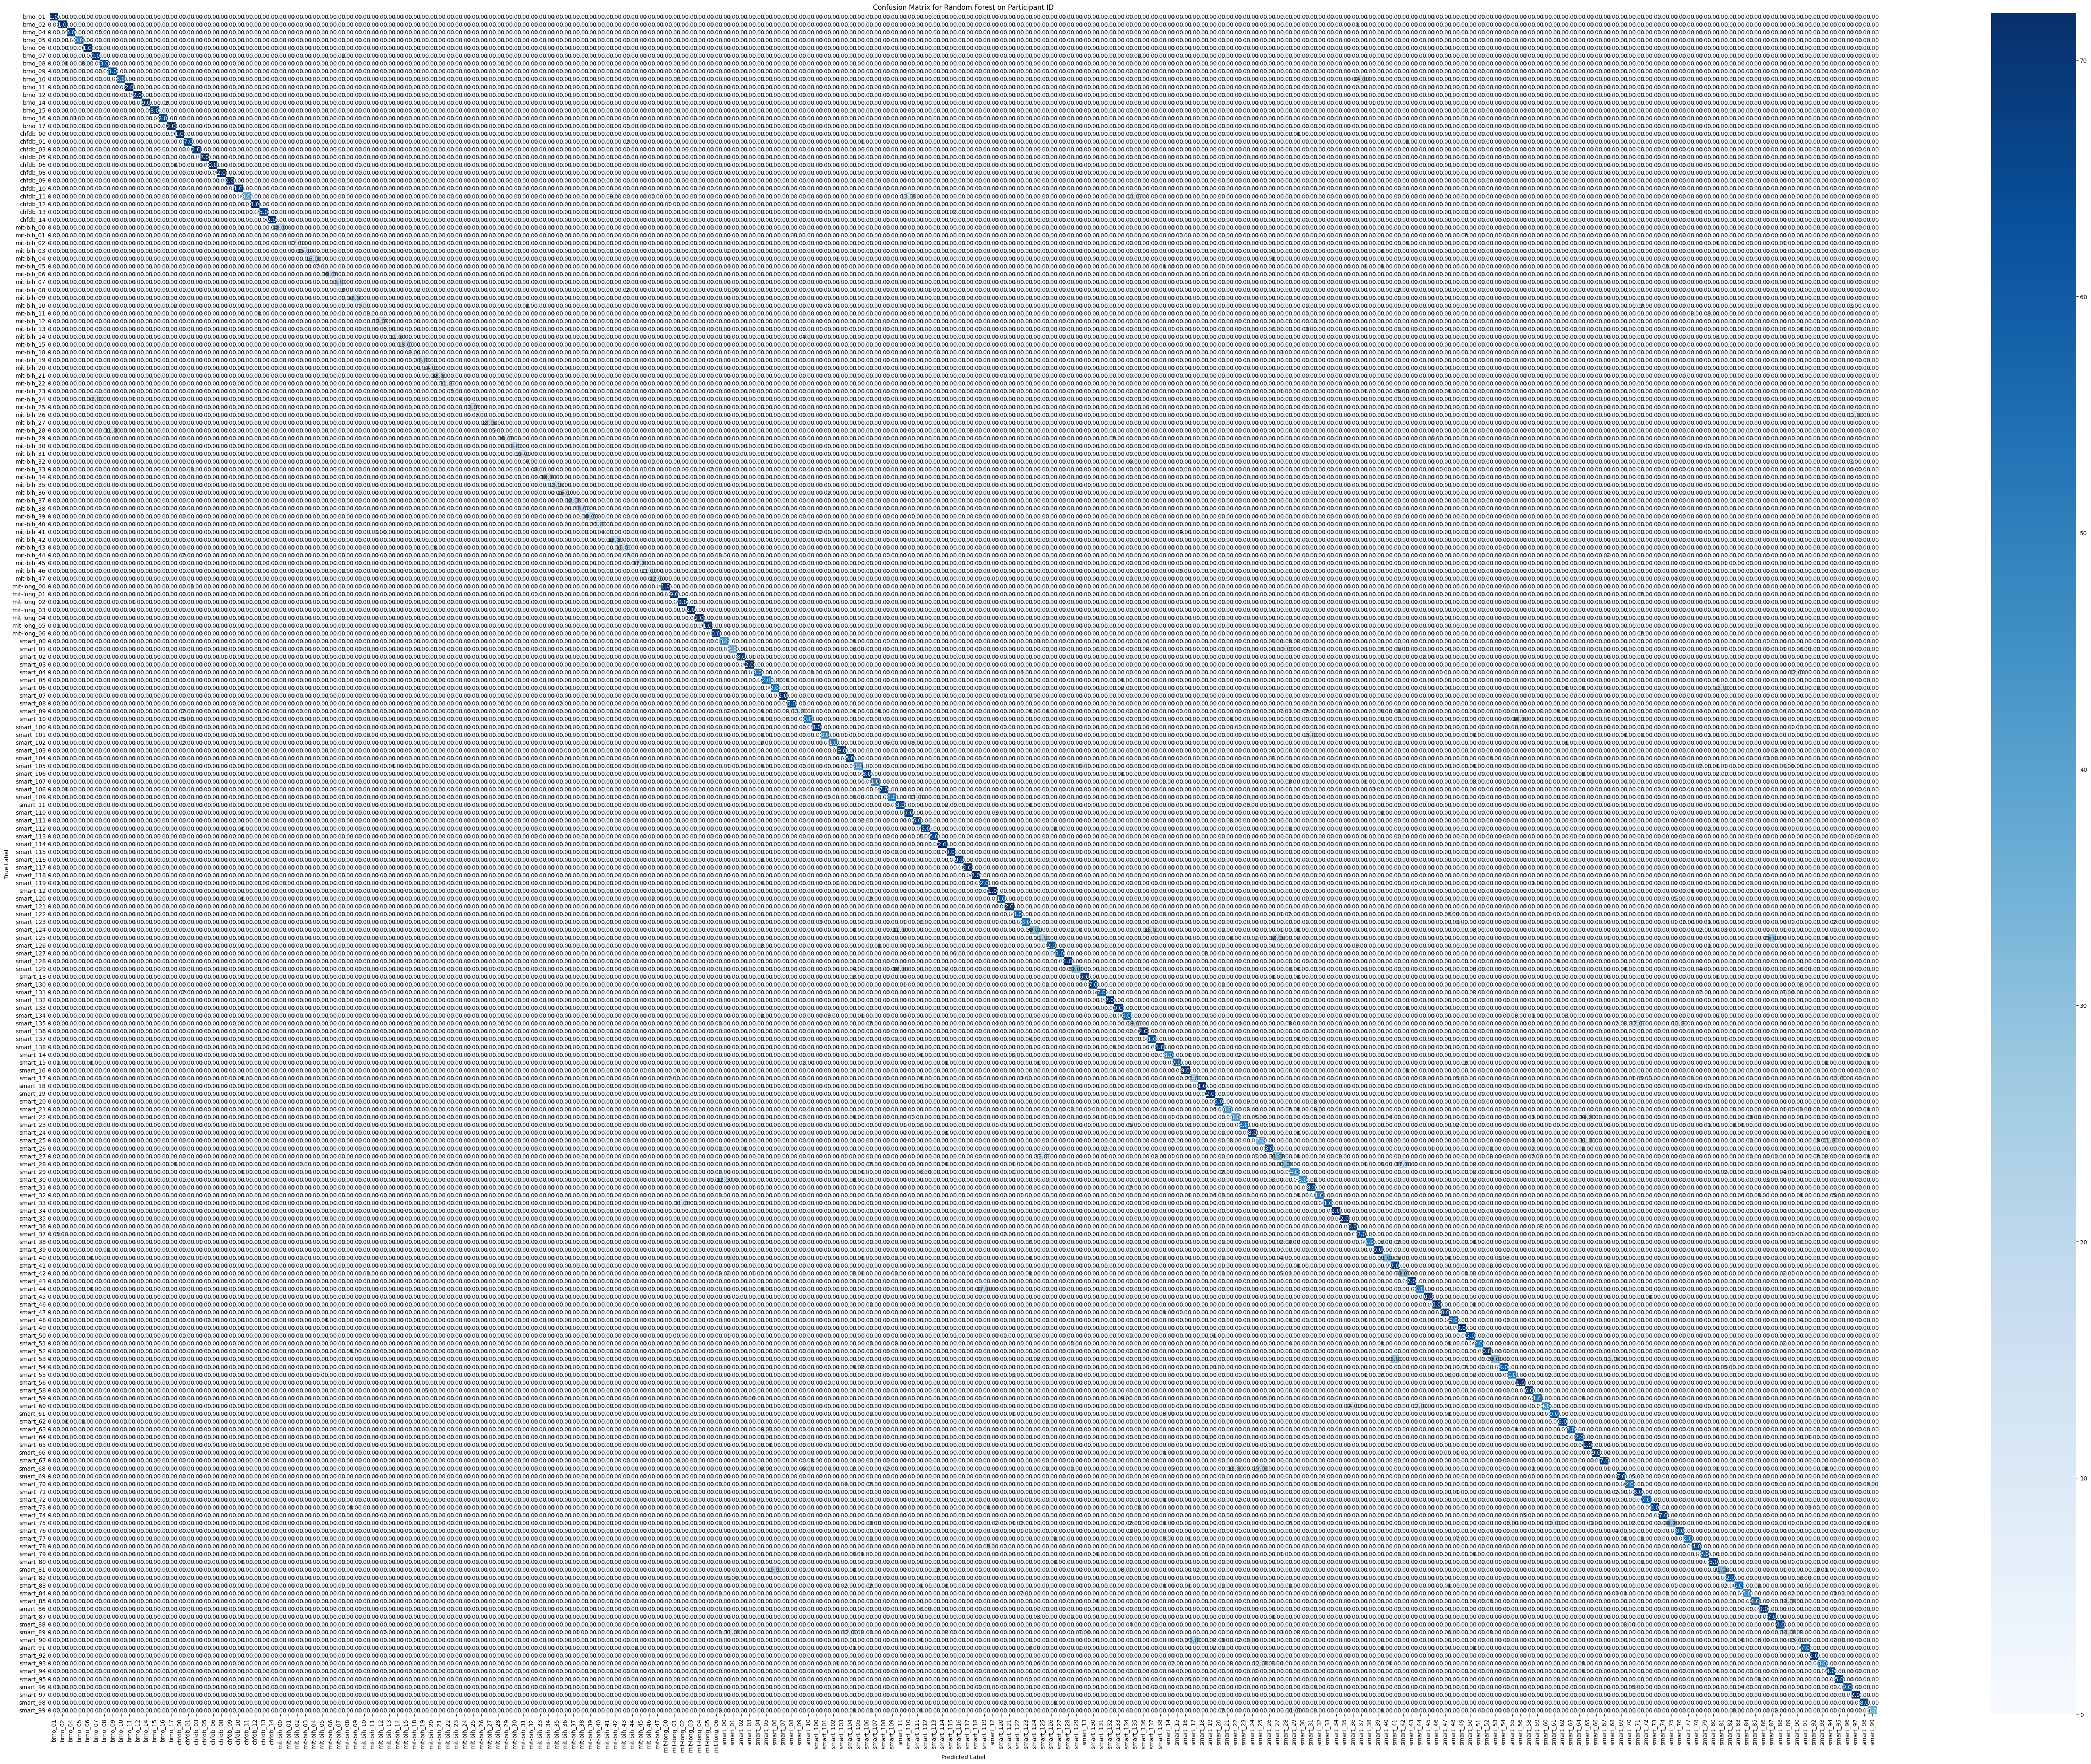

100%|===================| 217991/218000 [196:15<00:00]        


Model: XGBoost
Selected best model with accuracy: 0.0271


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics:
Accuracy: 0.0271
Precision: 0.0323
Recall: 0.0271
F1-Score: 0.0198
ROC AUC: 0.5115


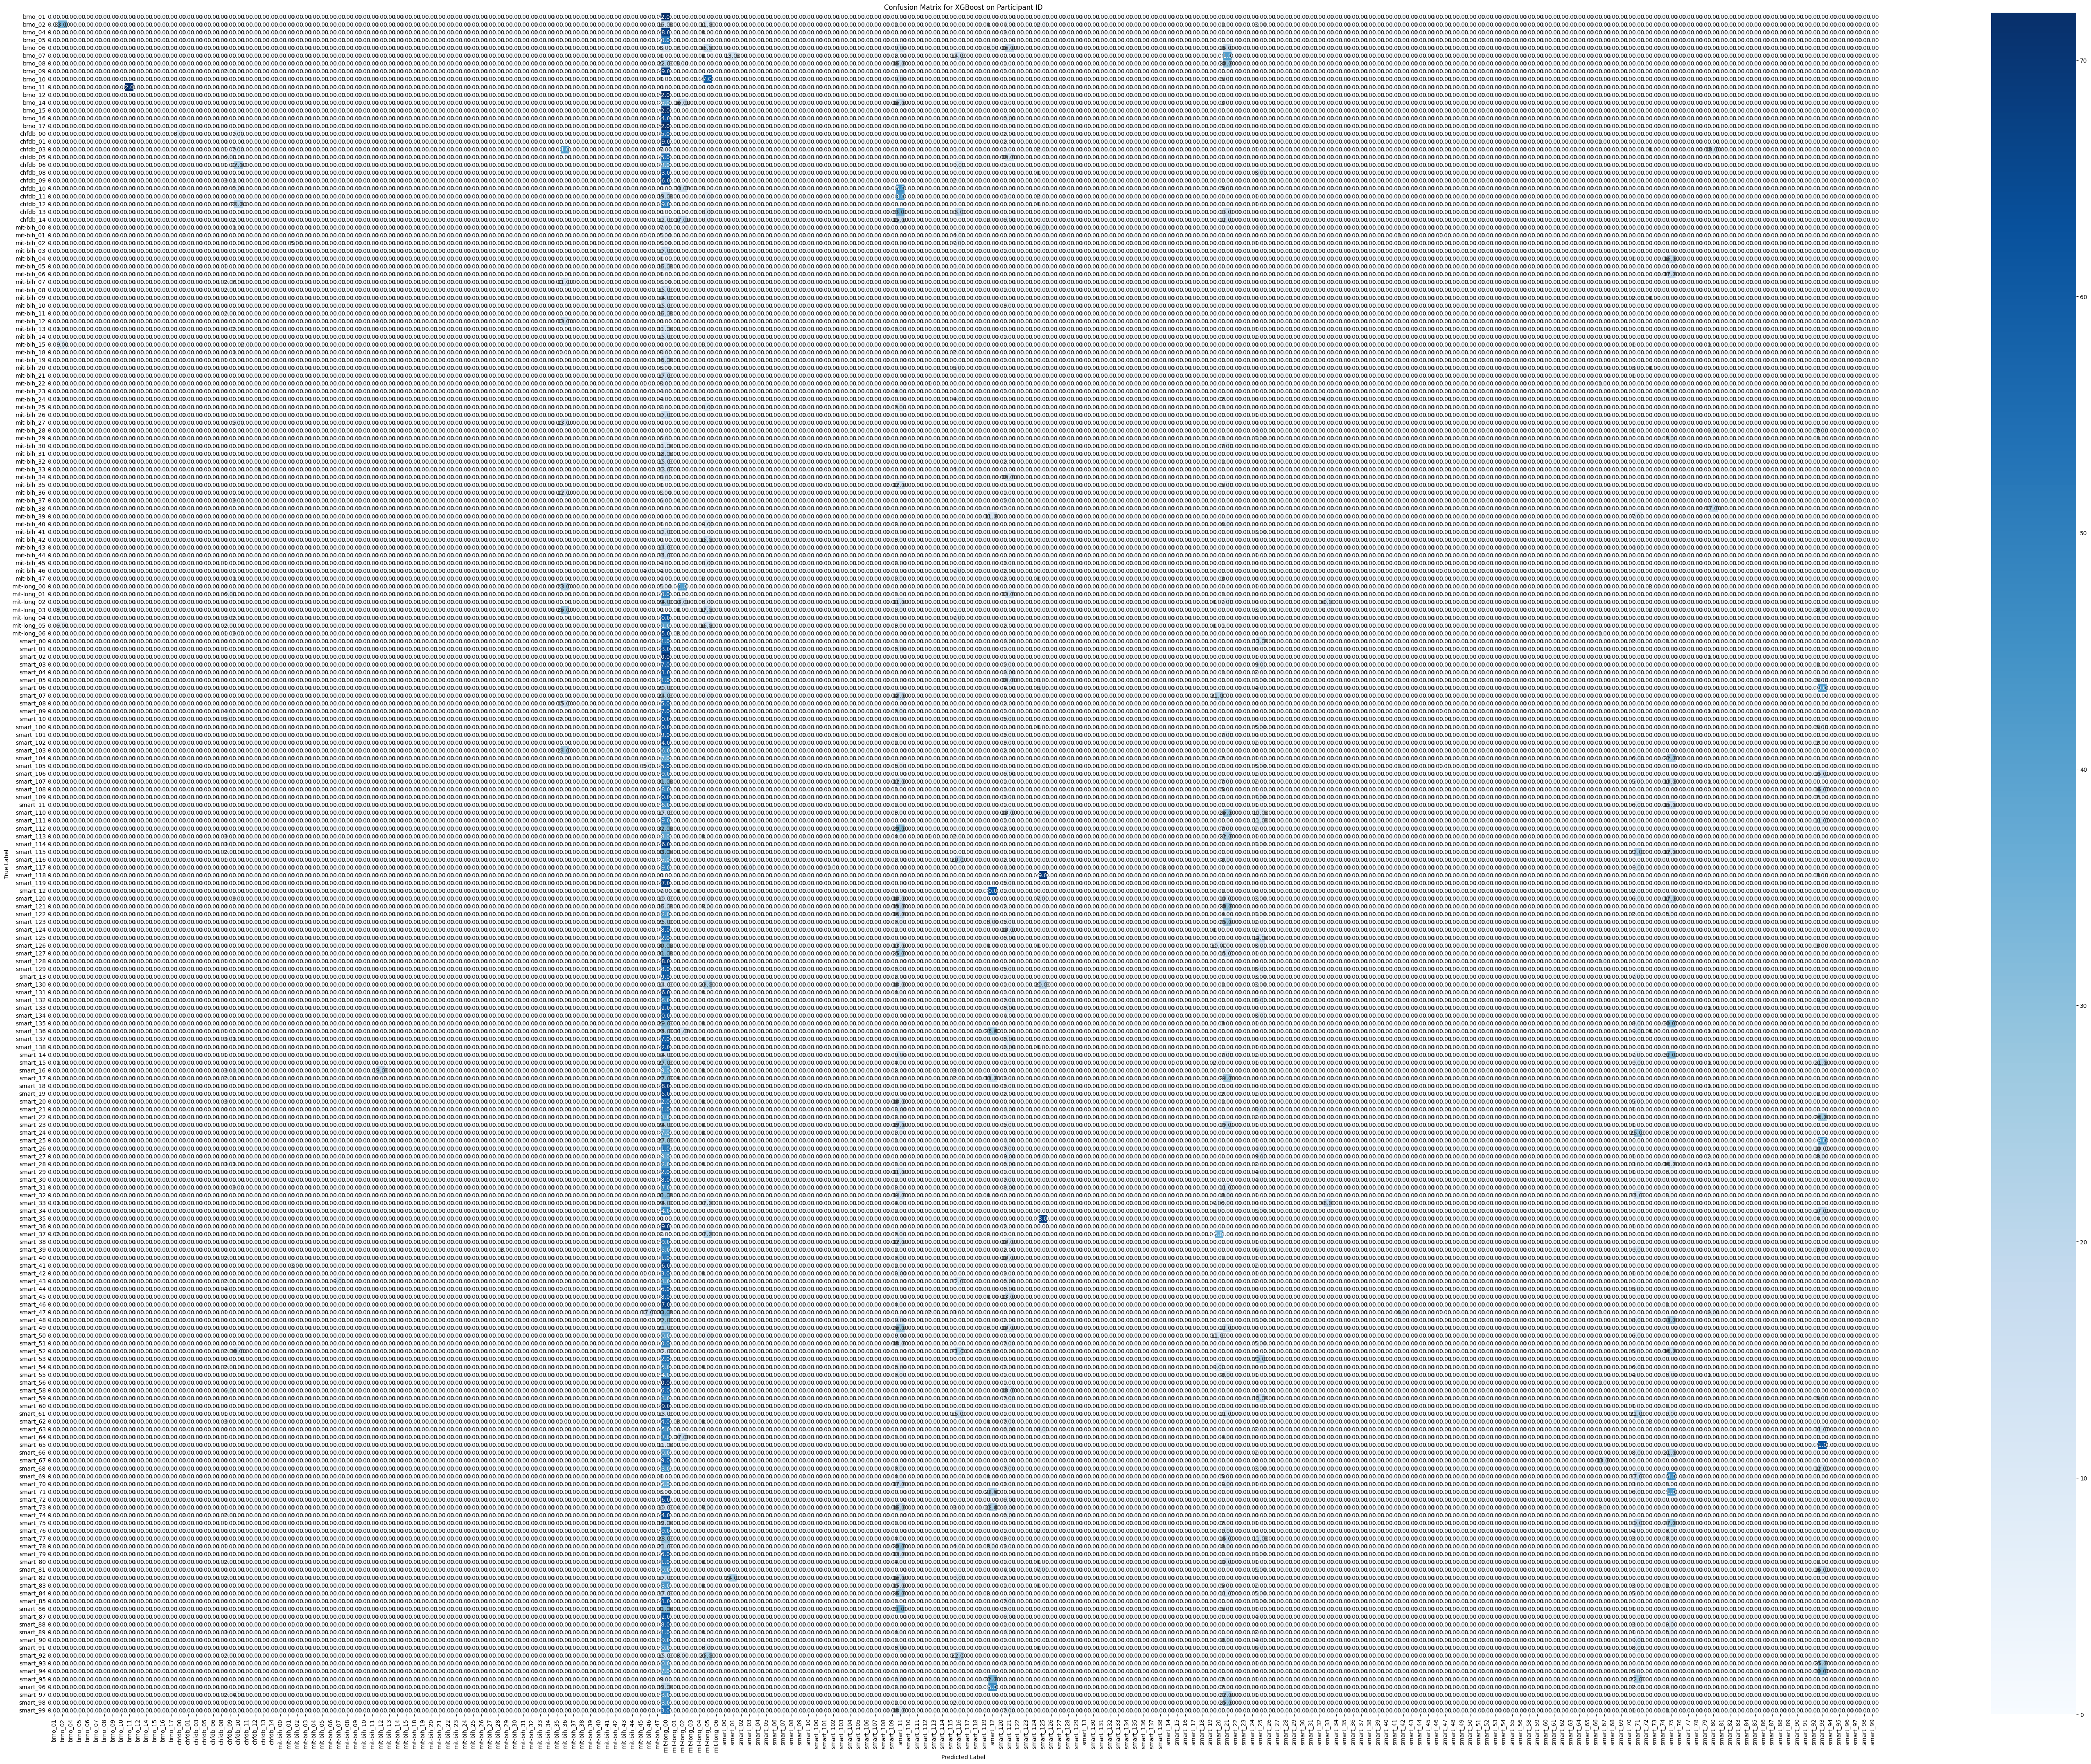

SHAP analysis failed on Participant ID with model XGBoost
GradientBoostingClassifier is only supported for binary classification right now!


In [4]:
# Participant ID Identification
train_data_id, test_data_id = time_series_split(combined_data, test_ratio=0.2)
X_train_id, y_train_id = prepare_features_labels(train_data_id, 'Participant', encode=False)
X_test_id, y_test_id = prepare_features_labels(test_data_id, 'Participant', encode=False)
print("\n--- Participant ID Identification ---")
for name, model in models.items():
    print(f"\nModel: {name}")
    evaluate_model(model, X_train_id, y_train_id, X_test_id, y_test_id, model_name=name, task='Participant ID')

In [ ]:
# Convert IDs to strings
y_train_id = y_train_id.astype(str)

# Now check the unique values
print("Unique values in 'y_train_id':", np.unique(y_train_id))

# Check for NaN values after conversion
print("Number of NaN values in 'y_train_id':", y_train_id.isnull().sum())
